## Action Recognition

### Imports

In [2]:
import collections
import os
import sys
import time
from typing import Tuple, List

import cv2
import numpy as np
from IPython import display
from openvino.runtime import Core
from openvino.runtime.ie_api import CompiledModel

sys.path.append("../utils")
import notebook_utils as utils

### Download model

In [3]:
base_model_dir = "model"
model_name = "action-recognition-0001"

precision = "FP16"
model_path_decoder = (
    f"./model/intel/{model_name}/{model_name}-decoder/{precision}/{model_name}-decoder.xml"
)

model_path_encoder = (
    f"./model/intel/{model_name}/{model_name}-encoder/{precision}/{model_name}-encoder.xml"
)

if not os.path.exists(model_path_decoder) or not os.path.exists(model_path_encoder):
    download_command = f"omz_downloader --name {model_name} --precision {precision} --output_dir {base_model_dir}" 

    # ! $download_command

### Load your labels

In [4]:
labels = "data/kinetics.txt"

with open(labels) as f:
    labels = [line.strip() for line in f]

print(labels[0:9], np.shape(labels))

['abseiling', 'air drumming', 'answering questions', 'applauding', 'applying cream', 'archery', 'arm wrestling', 'arranging flowers', 'assembling computer'] (400,)


## Load the models

### Model Initialization function

In [5]:
def model_init(model_path) -> Tuple:
    """
    Read the network and weights from a file, load the model on CPU
    and get input and output names of nodes

    :param: model: architecture path *.xml
    :returns:
        compiled_model: Compiled model
        input_key: Input node for model
        output_key: Output node for model
    """
    ie_core = Core()

    model = ie_core.read_model(model_path)
    compiled_model = ie_core.compile_model(model=model, device_name="CPU")

    input_keys = compiled_model.input(0)
    output_keys = compiled_model.output(0)

    # debug
    print(f"input_keys: {input_keys}")
    print(f"output_keys: {output_keys}")

    return input_keys, output_keys, compiled_model

### Initialization for encoder and decoder

In [6]:
input_key_en, output_keys_en, compiled_model_en = model_init(model_path_encoder)

input_key_de, output_keys_de, compiled_model_de = model_init(model_path_decoder)

height_en, width_en = list(input_key_en.shape)[2:]
frames2decode = list(input_key_de.shape)[0:][1]

# debug
print(f"frames2decode: {frames2decode}")

input_keys: <ConstOutput: names[0] shape{1,3,224,224} type: f32>
output_keys: <ConstOutput: names[371] shape{1,512,1,1} type: f32>
input_keys: <ConstOutput: names[0] shape{1,16,512} type: f32>
output_keys: <ConstOutput: names[674] shape{1,400} type: f32>
frames2decode: 16


### Helper functions

In [7]:
def center_crop(frame: np.ndarray) -> np.ndarray:
    """
    Center crop squared the original frame to standardize the input image to the encoder model

    :param frame: input frame
    :returns: center-crop-squared frame
    """

    height, width, _ = frame.shape
    min_dim = min(height, width)
    start_x = int((width - min_dim) / 2.0)
    start_y = int((height - min_dim) / 2.0)
    roi = [start_y, (start_y + min_dim), start_x, (start_x + min_dim)]
    return frame[start_y : (start_y + min_dim), start_x : (start_x + min_dim), ...], roi


def adaptive_resize(frame: np.ndarray, size: int) -> np.ndarray:
    """
    The frame going to be resized to have a height of size or a width of size

    :param frame: input frame
    :param size: input size to encoder model
    :returns: resized frame, np.array type
    """

    h, w, _ = frame.shape
    scale = size / min(h, w)
    w_scaled, h_scaled = int(w * scale), int(h * scale)
    if w_scaled == w and h_scaled == h:
        return frame
    return cv2.resize(frame, (w_scaled, h_scaled))


def decode_output(probs: np.ndarray, labels: np.ndarray, top_k: int=3) -> np.ndarray:
    """
    Decodes top probabilities into corresponding label names

    :param probs: confidence vector for 400 actions
    :param labels: list of actions
    :param top_k: The k most probable positions in the list of labels
    :returns: decoded_labels: the k most probable actions from the labels list
              decoded_top_probs: confidence fot the k most probable actions
    """

    top_ind = np.argsort(-1 * probs)[:top_k]
    out_label = np.array(labels)[top_ind.astype(int)]
    decoded_labels = [out_label[0][0], out_label[0][1], out_label[0][2]]
    top_probs = np.array(probs)[0][top_ind.astype(int)]
    decoded_top_probs = [top_probs[0][0], top_probs[0][1], top_probs[0][2]]

    # debug
    print(f"top_ind: {top_ind}")
    print(f"decoded_labels: {decoded_labels}")
    print(f"decoded_top_probs: {decoded_top_probs}")

    return decoded_labels, decoded_top_probs

def rec_frame_display(frame: np.ndarray, roi) -> np.ndarray:
    """
    Draw a rec frame over actual frame

    :param frame: input frame
    :param roi: Region of interest, image section processed by the Encoder
    :returns: frame with drawed shape
    """
    # debug
    print(roi[2])
    print(roi[0])

    cv2.line(frame, (roi[2] + 3, roi[0] + 3), (roi[2] + 3, roi[0] + 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[2] + 3, roi[0] + 3), (roi[2] + 100, roi[0] + 3), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[1] - 3), (roi[3] - 3, roi[1] - 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[1] - 3), (roi[3] - 100, roi[1] - 3), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[0] + 3), (roi[3] - 3, roi[0] + 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[3] - 3, roi[0] + 3), (roi[3] - 100, roi[0] + 3), (0, 200, 0), 2)
    cv2.line(frame, (roi[2] + 3, roi[1] - 3), (roi[2] + 3, roi[1] - 100), (0, 200, 0), 2)
    cv2.line(frame, (roi[2] + 3, roi[1] - 3), (roi[2] + 100, roi[1] - 3), (0, 200, 0), 2)

    FONT_STYLE = cv2.FONT_HERSHEY_COMPLEX
    org = (roi[2] + 3, roi[1] - 3)
    org2 = (roi[2] + 2, roi[1] - 2)
    FONT_SIZE = 0.5
    FONT_COLOR = (0, 200, 0)
    FONT_COLOR2 = (0, 0, 0)
    cv2.putText(frame, "ROI", org2, FONT_STYLE, FONT_SIZE, FONT_COLOR2)
    cv2.putText(frame, "ROI", org, FONT_STYLE, FONT_SIZE, FONT_COLOR)
    return frame

def display_text_fnc(frame: np.ndarray, display_text: str, index: int):
    """
    Include a text on the analyzed frame

    :param frame: input frame
    :param display_text: text to add on the frame
    :param index: index line dor adding text
    """

    FONT_COLOR = (255, 255, 255)
    FONT_COLOR2 = (0, 0, 0)
    FONT_STYLE = cv2.FONT_HERSHEY_COMPLEX
    FONT_SIZE = 0.7
    TEXT_VERTICAL_INTERVAL = 25
    TEXT_LEFT_MARGIN = 15
    (processed, roi) = center_crop(frame)

    frame = rec_frame_display(frame, roi)
    
    text_loc = (TEXT_LEFT_MARGIN, TEXT_VERTICAL_INTERVAL * (index + 1))
    text_loc2 = (TEXT_LEFT_MARGIN + 1, TEXT_VERTICAL_INTERVAL * (index + 1) + 1)
    cv2.putText(frame, display_text, text_loc2, FONT_STYLE, FONT_SIZE, FONT_COLOR2)
    cv2.putText(frame, display_text, text_loc, FONT_STYLE, FONT_SIZE, FONT_COLOR)

### AI functions

In [8]:
def preprocessing(frame: np.ndarray, size: int) -> np.ndarray:
    """
    Preparing frame before Encoder.
    The image should be scaled to its shortest dimension at "size"
    and cropped, centered, and squared so that oth width and height
    have lengths "size". The frame must be transposed from
    HWC to CHW

    :param frame: input frame
    :param size: input size to encoder model
    :returns : resized and cropped frame
    """

    preprocessed = adaptive_resize(frame, size)
    (preprocessed, roi) = center_crop(preprocessed)
    preprocessed = preprocessed.transpose((2, 0, 1))[None, ]

    return preprocessed, roi


def encoder(preprocessed: np.ndarray, compiled_model: CompiledModel) -> List:
    """
    Encoder Inference per frame. This funcition calls the network preiously
    configured fro the encoder model (compiled model), extracts the data
    from the output node, and appends it in an array to be used by the decoder

    :param: preprocessed: preprocessing frame
    :param: compiled_model: Encoder model network
    :returns: encoder_output: embedding layer that is append with each arriving frame
    """

    output_keys_en = compiled_model.output(0)

    infer_result_encoder = compiled_model([preprocessed])[output_keys_en]
    return infer_result_encoder


def decoder(encoder_output: list, compiled_model_de: CompiledModel) -> List:
    """
    Decoder inference per set of frames this function concatenates the embedding layer
    froms the encoder output, transpose the array to atch with the decoder input size.
    Calls the network previously configured fot the decoder model (compiled_model_de), etracts]
    the logits and normalize those to get confidence values along specified axis.
    Decoders top probabilities into corresponding label names.

    :param: encoder_output: embedding layer for 16 frames
    :param: compiled_model_de: Decoder model network
    :returns: decoded labels: The k most probable actions from the labels list
              decoded_top_probs: confidence for the k most probable actions
    """

    decoder_input = np.concatenate(encoder_output, axis=0)

    decoder_input = decoder_input.transpose((2, 0, 1, 3))
    decoder_input = np.squeeze(decoder_input, axis=3)
    output_key_de = compiled_model_de.output(0)

    result_de = compiled_model_de([decoder_input])[output_key_de]
    probs = softmax(result_de - np.max(result_de))

    decoded_labels, decoded_top_probs = decode_output(probs, labels, top_k=3)
    return decoded_labels, decoded_top_probs

def softmax(x: np.ndarray) -> np.ndarray:
    """
    Normalizes logits to get confidence values along specified axis
    X: np.array, axis=None
    """

    exp = np.exp(x)
    print(exp)
    return exp / np.sum(exp, axis=None)


### Main Processing function

In [9]:
def run_action_recognition(
    source: str = "0",
    flip: bool = True,
    use_popup: bool = False,
    compiled_model_en: CompiledModel = compiled_model_en,
    compiled_model_de: CompiledModel = compiled_model_de,
    skip_first_frames: int = 0,
):
    """
    Use the "source" webcam or video file to run the complete pipeline for action-recognition problem
    1. Create a video player to play with target fps
    2. Prepare a set of frames to be encoded-decoded
    3. Preprocess frame before Encoder
    4. Encoder Inference per frame
    5. Decoder inference per set of frames
    6. Visualize the results

    :param: source: webcam "0" or video path
    :param: flip: to be used by VideoPlayer function for flipping capture image
    :param: use_popup: False for showing encoded frames over this notebook, True for creating a popup window.
    :param: skip_first_frames: Number of frames to skip at the beginning of the video.
    :returns: display video over the notebook or in a popup window
    """

    size = height_en
    sample_duration = frames2decode
    fps = 30
    player = None
    try:
        player = utils.VideoPlayer(source, flip=flip, fps=fps, skip_first_frames=skip_first_frames)
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(title, cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)
        
        processing_times = collections.deque()
        processing_time = 0
        encoder_output = []
        decoded_labels = [0, 0, 0]
        decoded_top_probs = [0, 0, 0]
        counter = 0

        text_inference_template = "Infer Time:{Time:.1f}ms, {fps:.1f}FPS"
        text_template = "{label}, {conf:.2f} %"

        while True:
            counter = counter + 1

            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            
            scale = 1280 / max(frame.shape)

            if scale < 1:
                frame = cv2.resize(frame, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)
            
            if counter % 2 == 0:
                (preprocessed, _) = preprocessing(frame, size)

                start_time = time.time()

                encoder_output.append(encoder(preprocessed, compiled_model_en))

                if len(encoder_output) == sample_duration:
                    decoded_labels, decoded_top_probs = decoder(encoder_output, compiled_model_de)
                    encoder_output = []

                stop_time = time.time()

                processing_times.append(stop_time - start_time)

                if len(processing_times) > 200:
                    processing_times.popleft()

                processing_time = np.mean(processing_times) * 1000
                fps = 1000 / processing_time

            for i in range(0, 3):
                display_text = text_template.format(
                    label=decoded_labels[i],
                    conf=decoded_top_probs[i] * 100
                )
                display_text_fnc(frame, display_text, i)

            display_text = text_inference_template.format(Time=processing_time, fps=fps)
            display_text_fnc(frame, display_text, 3)

            if use_popup:
                cv2.imshow(title, frame)
                key = cv2.waitKey(1)
                if key == 27:
                    break
            else:
                _, encoded_img = cv2.imencode(".jpg", frame, params=[cv2.IMWRITE_JPEG_QUALITY, 90])
                i = display.Image(data=encoded_img)
                display.clear_output(wait=True)
                display.display(i)

    except KeyboardInterrupt:
        print("Interrupted")
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()
    

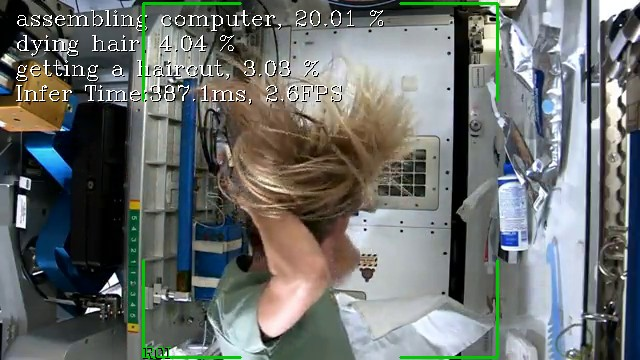

140Interrupted


In [10]:
video_file = "https://archive.org/serve/ISSVideoResourceLifeOnStation720p/ISS%20Video%20Resource_LifeOnStation_720p.mp4"
run_action_recognition(source=video_file, flip=False, use_popup=False, skip_first_frames=600)

### run action recognition using a webcam

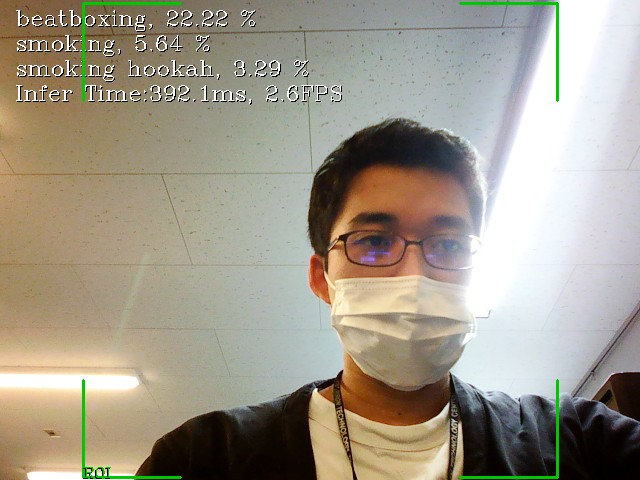

Interrupted


In [11]:
run_action_recognition(source=0, flip=False, use_popup=False, skip_first_frames=0)